### just selection using neural networks

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from torch.utils.data import DataLoader, TensorDataset

In [8]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

def generate_embedding_space(n_points=100):
    cluster1 = np.random.normal(loc=[-2, -2], scale=0.5, size=(n_points//2, 2))
    cluster2 = np.random.normal(loc=[2, 2], scale=0.5, size=(n_points//2, 2))
    embeddings = np.vstack([cluster1, cluster2])
    return torch.FloatTensor(embeddings)

In [17]:
class PointSelector(nn.Module):
    def __init__(self):
        super(PointSelector, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x)
    
def calculate_batch_distance_loss(embeddings, selections, top_k=5):
    """Calculate loss based on distances between selected points in a batch"""
    batch_size = embeddings.shape[0]
    
    # Get top k selections
    _, top_indices = torch.topk(selections.squeeze(), k=min(top_k, batch_size))
    selected_points = embeddings[top_indices]
    
    # Calculate pairwise distances between selected points
    distances = torch.pdist(selected_points)
    
    # Loss is negative mean of distances (we want to maximize distances)
    distance_loss = -torch.mean(distances)
    
    # Add regularization to prevent selecting the same point multiple times
    selection_loss = torch.mean(selections)
    
    return distance_loss + 0.1 * selection_loss


def train_selector(model, embeddings, batch_size=32, n_epochs=1000):
    optimizer = optim.Adam(model.parameters(), lr=0.000001)
    dataset = TensorDataset(embeddings)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    losses = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        num_batches = 0
        
        for batch in dataloader:
            batch_embeddings = batch[0]
            optimizer.zero_grad()
            
            # Get selections for this batch
            selections = model(batch_embeddings)
            
            # Calculate loss
            loss = calculate_batch_distance_loss(batch_embeddings, selections)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_epoch_loss = epoch_loss / num_batches
        losses.append(avg_epoch_loss)
        
        if (epoch + 1) % 200 == 0:
            print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}")
    
    return losses

In [18]:
def find_max_distance_points(embeddings_np, k=5):
    """Find k points that maximize the sum of pairwise distances."""
    n_points = len(embeddings_np)
    best_points = None
    max_total_distance = -1
    
    # Try 1000 random combinations to find a good solution
    for _ in range(1000):
        # Randomly select k points
        indices = np.random.choice(n_points, k, replace=False)
        points = embeddings_np[indices]
        
        # Calculate sum of pairwise distances
        total_distance = sum(np.linalg.norm(p1 - p2) 
                           for p1, p2 in combinations(points, 2))
        
        if total_distance > max_total_distance:
            max_total_distance = total_distance
            best_points = indices
    
    return best_points

def plot_results(embeddings, nn_selections, losses, model):
    plt.figure(figsize=(20, 5))
    embeddings_np = embeddings.detach().numpy()
    
    # Plot 1: Neural network selections
    plt.subplot(1, 4, 1)
    plt.scatter(embeddings_np[:, 0], embeddings_np[:, 1],
               c='lightgray', label='Not Selected', alpha=0.5)
    
    # Get top 5 points based on neural network selection
    selections_np = nn_selections.detach().numpy()
    top_5_indices = np.argsort(selections_np.squeeze())[-5:]
    
    # Plot selected points
    selected_points = embeddings_np[top_5_indices]
    plt.scatter(selected_points[:, 0], selected_points[:, 1],
               c='red', label='Top 5 Selected', alpha=0.8, s=100)
    
    # Draw lines between selected points
    for i, j in combinations(range(len(selected_points)), 2):
        plt.plot([selected_points[i, 0], selected_points[j, 0]],
                [selected_points[i, 1], selected_points[j, 1]],
                'r--', alpha=0.2)
    
    plt.title('Neural Network Top 5 Selection')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Maximum distance points
    plt.subplot(1, 4, 2)
    plt.scatter(embeddings_np[:, 0], embeddings_np[:, 1],
               c='lightgray', label='Not Selected', alpha=0.5)
    
    # Find and plot maximum distance points
    max_dist_indices = find_max_distance_points(embeddings_np)
    max_dist_points = embeddings_np[max_dist_indices]
    
    plt.scatter(max_dist_points[:, 0], max_dist_points[:, 1],
               c='blue', label='Max Distance Points', alpha=0.8, s=100)
    
    # Draw lines between max distance points
    for i, j in combinations(range(len(max_dist_points)), 2):
        plt.plot([max_dist_points[i, 0], max_dist_points[j, 0]],
                [max_dist_points[i, 1], max_dist_points[j, 1]],
                'b--', alpha=0.2)
    
    plt.title('Maximum Distance Points')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.grid(True)
    
    # Plot 3: Training loss
    plt.subplot(1, 4, 3)
    plt.plot(losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Plot 4: Selection probability heatmap
    plt.subplot(1, 4, 4)
    x = np.linspace(min(embeddings_np[:, 0]), max(embeddings_np[:, 0]), 100)
    y = np.linspace(min(embeddings_np[:, 1]), max(embeddings_np[:, 1]), 100)
    X, Y = np.meshgrid(x, y)
    grid_points = torch.FloatTensor(np.column_stack((X.ravel(), Y.ravel())))
    
    with torch.no_grad():
        Z = model(grid_points).numpy().reshape(X.shape)
    
    plt.imshow(Z, extent=[min(x), max(x), min(y), max(y)],
               origin='lower', cmap='viridis', aspect='auto')
    plt.colorbar(label='Selection Probability')
    plt.scatter(embeddings_np[:, 0], embeddings_np[:, 1],
               c='white', alpha=0.5, s=20)
    plt.title('Selection Probability Heatmap')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    plt.tight_layout()
    plt.show()
    
    # Print distance metrics for comparison
    nn_total_distance = sum(np.linalg.norm(p1 - p2)
                          for p1, p2 in combinations(selected_points, 2))
    max_dist_total = sum(np.linalg.norm(p1 - p2)
                       for p1, p2 in combinations(max_dist_points, 2))
    
    print(f"\nTotal pairwise distances:")
    print(f"Neural Network Selection: {nn_total_distance:.2f}")
    print(f"Maximum Distance Points: {max_dist_total:.2f}")


Epoch 200, Loss: -0.6112
Epoch 400, Loss: -1.0799
Epoch 600, Loss: -0.6740
Epoch 800, Loss: -0.6170
Epoch 1000, Loss: -1.0801
Epoch 1200, Loss: -0.6146
Epoch 1400, Loss: -1.0803
Epoch 1600, Loss: -0.7700
Epoch 1800, Loss: -1.0525
Epoch 2000, Loss: -0.5750
Epoch 2200, Loss: -0.9028
Epoch 2400, Loss: -0.8970
Epoch 2600, Loss: -0.8570
Epoch 2800, Loss: -0.6122
Epoch 3000, Loss: -0.5626
Epoch 3200, Loss: -0.6764
Epoch 3400, Loss: -0.9997
Epoch 3600, Loss: -1.0057
Epoch 3800, Loss: -0.9554
Epoch 4000, Loss: -0.8045
Epoch 4200, Loss: -0.7079
Epoch 4400, Loss: -0.7028
Epoch 4600, Loss: -0.9916
Epoch 4800, Loss: -0.6840
Epoch 5000, Loss: -0.8531
Epoch 5200, Loss: -0.5080
Epoch 5400, Loss: -0.7816
Epoch 5600, Loss: -0.9916
Epoch 5800, Loss: -0.5627
Epoch 6000, Loss: -0.5906
Epoch 6200, Loss: -0.7577
Epoch 6400, Loss: -0.5458
Epoch 6600, Loss: -1.1075
Epoch 6800, Loss: -1.1516
Epoch 7000, Loss: -0.7993
Epoch 7200, Loss: -0.5032
Epoch 7400, Loss: -0.6876
Epoch 7600, Loss: -0.7984
Epoch 7800, Loss

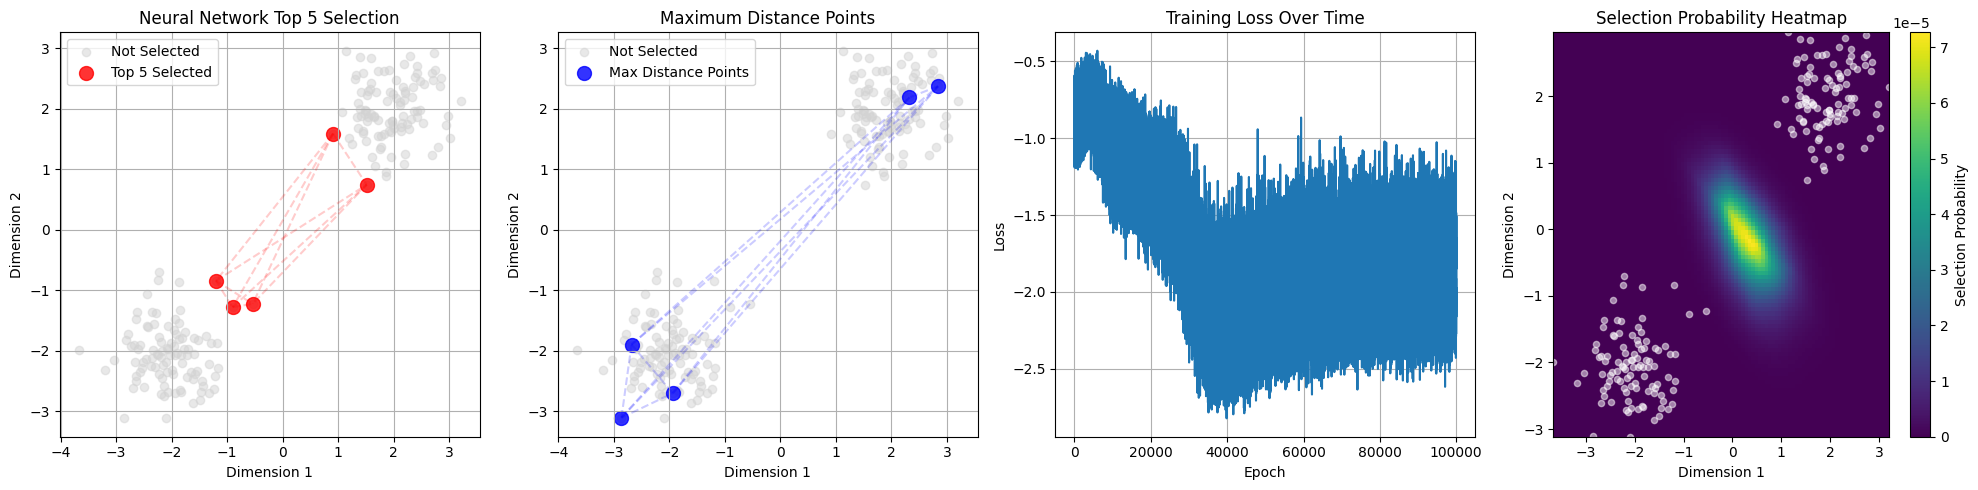


Total pairwise distances:
Neural Network Selection: 21.62
Maximum Distance Points: 46.10


In [19]:
if __name__ == "__main__":
    # Generate embedding space
    embeddings = generate_embedding_space(200)
    
    # Create and train the model
    model = PointSelector()
    losses = train_selector(model, embeddings,n_epochs=100000)
    
    # Get neural network selections
    with torch.no_grad():
        selections = model(embeddings)
    
    # Visualize results
    plot_results(embeddings, selections, losses, model)

### usign qs-selector

In [7]:
import matplotlib.pylab as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import pairwise_distances
from IPython.display import Markdown

from selector.methods.distance import MaxMin, MaxSum, OptiSim, DISE
from selector.measures.diversity import compute_diversity

#### utility for plotting graph

In [8]:
def graph_data(
    data,
    indices=None,
    labels=None,
    reference=False,
    title="",
    xlabel="",
    ylabel="",
    number=False,
    fname=None,
):
    """Graphs the data in a scatter plot.

    Parameters
    ----------
    data : numpy.ndarray of shape (n_samples, 2)
        The original data points to be graphed.
    indices : list of numpy.ndarray, optional
        List of indices array of the data points selected.
    labels : list of str, optional
        List of labels denoting method for selected indices.
    reference : bool, optional
        Whether to highlight the first data point.
    title : str, optional
        The title of the plot.
    xlabel : str, optional
        The label of the x-axis.
    ylabel : str, optional
        The label of the y-axis.
    number : bool, optional
        Whether to label the selected data points with numbers representing the order of selection.
    fname : str, optional
        Filename for saving the figure. If None, figure is shown.

    """
    if data.ndim != 2 or data.shape[1] != 2:
        raise ValueError(f"Expect data to be a 2D array with 2 columns, got {data.shape}.")

    if labels is not None and len(indices) != len(labels):
        raise ValueError(
            f"Expect indices and labels to have the same length, got {len(indices)} and {len(labels)}."
        )

    # Add a title and axis labels
    plt.figure(dpi=100)
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # plot original data
    plt.scatter(data[:, 0], data[:, 1], marker="o", facecolors="none", edgecolors="0.75")

    colors = ["skyblue", "r", "b", "k", "g", "orange", "navy", "indigo", "pink", "purple", "yellow"]
    markers = ["o", "x", "*", "_", "|", "s", "p", ">", "<", "^", "v"]
    text_location = [(0.1, 0.1), (-0.1, 0.1)]
    colors_numbers = ["black", "red", "blue", "k", "k", "k", "k", "k", "k", "k", "k"]

    if indices:
        for index, selected_index in enumerate(indices):
            plt.scatter(
                data[selected_index, 0],
                data[selected_index, 1],
                c=colors[index],
                label=labels[index] if labels is not None else None,
                marker=markers[index],
            )
            if number:
                shift_x, shift_y = text_location[index]
                for i, mol_id in enumerate(selected_index):
                    plt.text(
                        data[mol_id, 0] + shift_x,
                        data[mol_id, 1] + shift_y,
                        str(i + 1),
                        c=colors_numbers[index],
                    )
    if reference:
        plt.scatter(data[0, 0], data[0, 1], c="black")
    if labels is not None:
        # plt.legend(loc="upper left", frameon=False)
        plt.legend(loc="best", frameon=False)
    if fname is not None:
        plt.savefig(fname, dpi=500)
    else:
        plt.show()

In [9]:
# define function to render tables easier


def render_table(data, caption=None, decimals=3):
    """Renders a list of lists in ta markdown table for easy visualization.

    Parameters
    ----------
    data : list of lists
        The data to be rendered in a table, each inner list represents a row with the first row
        being the header.
    caption : str, optional
        The caption of the table.
    decimals : int, optional
        The number of decimal places to round the data to.
    """

    # check all rows have the same number of columns
    if not all(len(row) == len(data[0]) for row in data):
        raise ValueError("Expect all rows to have the same number of columns.")

    if caption is not None:
        # check if caption is a string
        if not isinstance(caption, str):
            raise ValueError("Expect caption to be a string.")
        tmp_output = f"**{caption}**\n\n"

    # get the width of each column (transpose the data list and get the max length of each new row)
    colwidths = [max(len(str(s)) for s in col) + 2 for col in zip(*data)]

    # construct the header row
    header = f"| {' | '.join(f'{str(s):^{w}}' for s, w in zip(data[0], colwidths))} |"
    tmp_output += header + "\n"

    # construct a separator row
    separator = f"|{'|'.join(['-' * w for w in colwidths])}|"
    tmp_output += separator + "\n"

    # construct the data rows
    for row in data[1:]:
        # round the data to the specified number of decimal places
        row = [round(s, decimals) if isinstance(s, float) else s for s in row]
        row_str = f"| {' | '.join(f'{str(s):^{w}}' for s, w in zip(row, colwidths))} |"
        tmp_output += row_str + "\n"

    return display(Markdown(tmp_output))

#### making artificaial data using blobs from sklearn

In [2]:
# generate n_sample data in 2D feature space forming 1 cluster
X, labels = make_blobs(
    n_samples=500,
    n_features=2,
    centers=np.array([[0.0, 0.0]]),
    random_state=42,
)

# compute the (n_sample, n_sample) pairwise distance matrix
X_dist = pairwise_distances(X, metric="euclidean")

print("Shape of data   = ", X.shape)
print("Shape of labels = ", labels.shape)
print("Unique labels   = ", np.unique(labels))
print("Cluster size    = ", np.count_nonzero(labels == 0))
print("Shape of the distance array = ", X_dist.shape)

Shape of data   =  (500, 2)
Shape of labels =  (500,)
Unique labels   =  [0]
Cluster size    =  500
Shape of the distance array =  (500, 500)


In [16]:
import numpy as np
np.random.seed(42)


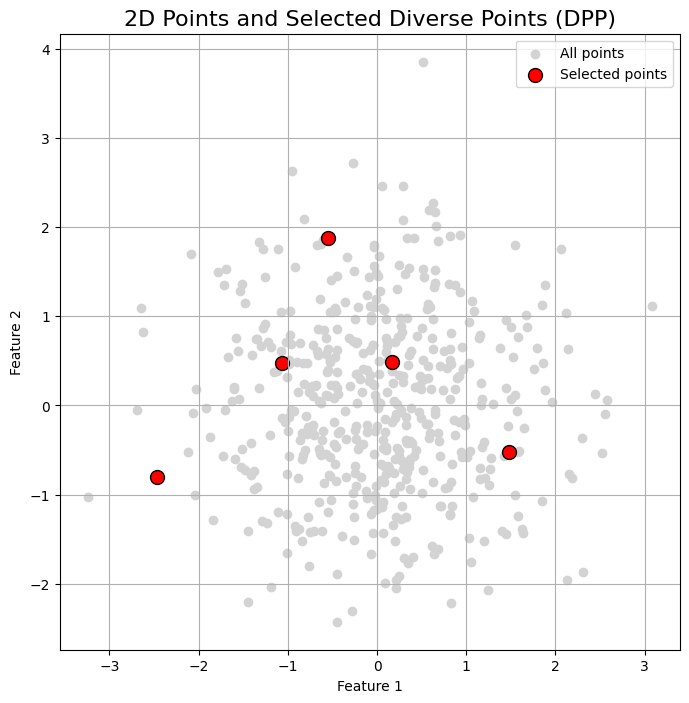

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
from dppy.finite_dpps import FiniteDPP
# Function to compute similarity matrix using RBF kernel
def compute_similarity_matrix(data, gamma=0.1):
    return np.exp(-gamma * X_dist ** 2)

# Create similarity matrix
similarity_matrix = compute_similarity_matrix(X)

# Initialize and sample from DPP
dpp = FiniteDPP(kernel_type='likelihood', projection=False, L=similarity_matrix)
dpp.sample_exact_k_dpp(size=5)  # Select 10 points
selected_indices = dpp.list_of_samples[0]
selected_points = X[selected_indices]


# Plot all points and selected points
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], color='lightgray', label='All points')
plt.scatter(selected_points[:, 0], selected_points[:, 1], color='red', label='Selected points', s=100, edgecolor='black')
plt.title('2D Points and Selected Diverse Points (DPP)', fontsize=16)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.show()


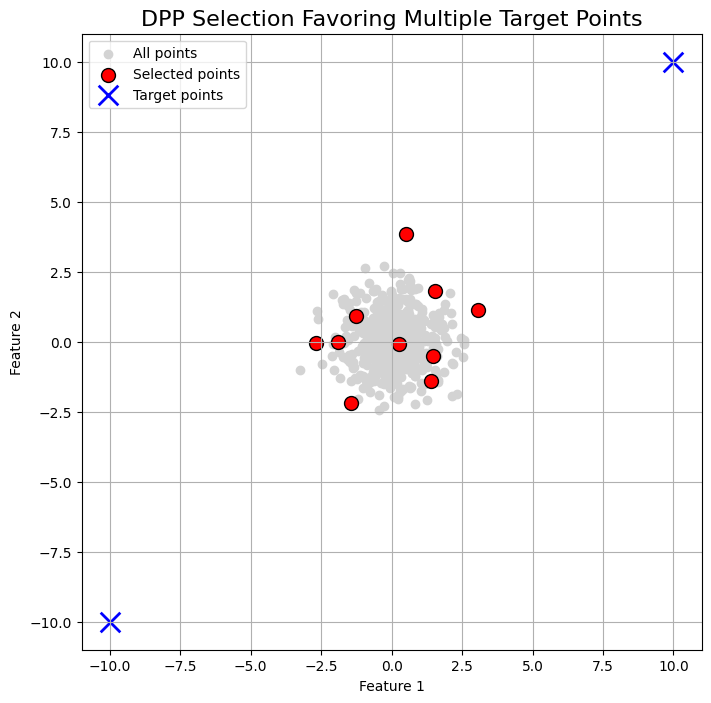

In [190]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
from dppy.finite_dpps import FiniteDPP

# Function to compute weighted similarity matrix for multiple target points
def compute_weighted_similarity_matrix_multi_targets(data, target_points, gamma=0.1, beta=0.5):
    total_weights = np.zeros(len(data))

    # Compute weights for each target point and sum them
    for target_point in target_points:
        distances_to_target = np.linalg.norm(data - target_point, axis=1)
        weights = np.exp(-beta * distances_to_target**2)  # Points closer to target_point have higher weights
        total_weights += weights

    pairwise_distances_matrix = pairwise_distances(data, metric="euclidean")
    similarity_matrix = np.exp(-gamma * pairwise_distances_matrix**2)

    # Adjust similarity matrix using total weights
    weighted_similarity_matrix = similarity_matrix * total_weights[:, np.newaxis]

    # Symmetrize the matrix
    symmetrized_matrix = (weighted_similarity_matrix + weighted_similarity_matrix.T) / 2

    # Ensure the matrix is positive semi-definite
    eig_vals, eig_vecs = np.linalg.eigh(symmetrized_matrix)
    eig_vals_clipped = np.clip(eig_vals, 0, None)  # Set negative eigenvalues to 0
    psd_matrix = eig_vecs @ np.diag(eig_vals_clipped) @ eig_vecs.T
    return psd_matrix

# Generate random data
X, labels = make_blobs(
    n_samples=500,
    n_features=2,
    centers=np.array([[0.0, 0.0]]),
    random_state=42,
)

# Example usage with multiple target points
target_points = np.array([[-10.0, -10.0],[10,10]])  # Favor these points
similarity_matrix = compute_weighted_similarity_matrix_multi_targets(X, target_points)

# Initialize and sample from DPP
dpp = FiniteDPP(kernel_type='likelihood', projection=False, L=similarity_matrix)
dpp.sample_exact_k_dpp(size=10)  # Select 10 points
selected_indices = dpp.list_of_samples[0]
selected_points = X[selected_indices]

# Plot all points, target points, and selected points
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], color='lightgray', label='All points')
plt.scatter(selected_points[:, 0], selected_points[:, 1], color='red', label='Selected points', s=100, edgecolor='black')
plt.scatter(target_points[:, 0], target_points[:, 1], color='blue', label='Target points', s=200, marker='x', linewidth=2)
plt.title('DPP Selection Favoring Multiple Target Points', fontsize=16)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.show()


In [122]:
# Calculate the distances between selected points and the target points
distances_to_target = np.linalg.norm(selected_points - target_points[0], axis=1)

# Calculate distances from all points to the target points
all_distances_to_target = np.linalg.norm(X - target_points[0], axis=1)

# Print out the minimum distance of all points to the target points
print("Minimum distance of all points to the target point:", np.sum(all_distances_to_target)/len(all_distances_to_target))

# Print out the sumimum distance of the selected points to the target points
print("sumimum distance of selected points to the target point:", np.sum(distances_to_target)/len(distances_to_target))


Minimum distance of all points to the target point: 1.227962344910015
sumimum distance of selected points to the target point: 1.3802107784806423


#### using the min max selector that maximizes the min distance between the points

In [10]:
# select samples using X_dist
collector = MaxMin()
indices_1 = collector.select(X_dist, size=5)

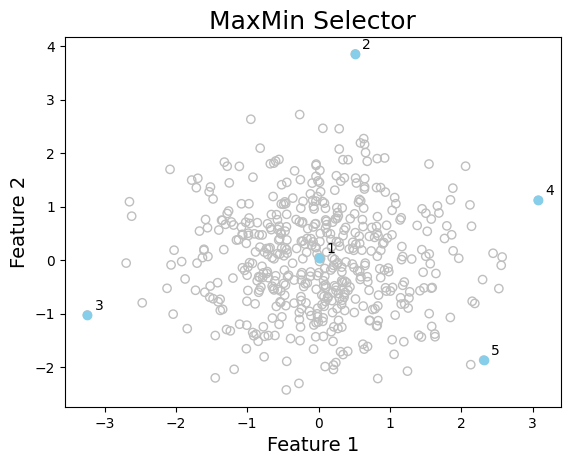

In [11]:
# select samples using X given a distance function (to compute the distance matrix)
collector = MaxMin(fun_dist=lambda x: pairwise_distances(x, metric="euclidean"))
indices_2 = collector.select(X, size=5)

# check if the selected samples are the same
assert indices_1 == indices_2

# visualize data and selected samples (in the order selected)
graph_data(
    X,
    indices=[indices_2],
    labels=None,
    title="MaxMin Selector",
    xlabel="Feature 1",
    ylabel="Feature 2",
    number=True,
)

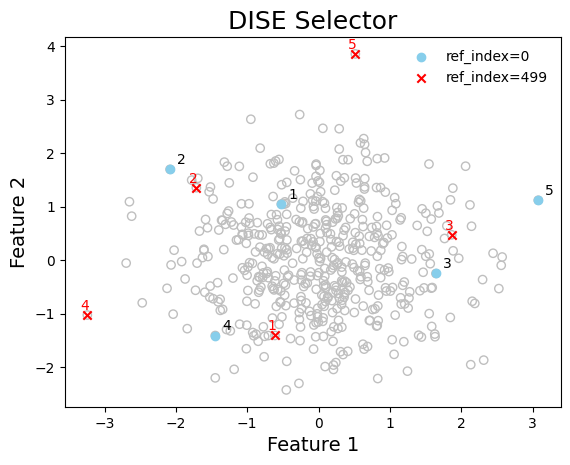

In [20]:
collector = DISE(ref_index=0, p=2)
indices_1 = collector.select(X_dist, size=5)

collector = DISE(ref_index=499, p=2)
indices_2 = collector.select(X_dist, size=5)

# visualize data and selected samples (in the order selected)
graph_data(
    X,
    indices=[indices_1, indices_2],
    labels=["ref_index=0", "ref_index=499"],
    title="DISE Selector",
    xlabel="Feature 1",
    ylabel="Feature 2",
    number=True,
)

In [21]:
# generate n_sample data in 2D feature space forming 3 clusters
X, labels = make_blobs(n_samples=500, n_features=2, centers=3, random_state=42)

# compute the (n_sample, n_sample) pairwise distance matrix
X_dist = pairwise_distances(X, metric="euclidean")

print("Shape of data   = ", X.shape)
print("Shape of labels = ", labels.shape)
print("Unique labels   = ", np.unique(labels))
size_0, size_1 = np.count_nonzero(labels == 0), np.count_nonzero(labels == 1)
print("Cluster sizes = ", size_0, size_1)
print("Shape of the distance array = ", X_dist.shape)

Shape of data   =  (500, 2)
Shape of labels =  (500,)
Unique labels   =  [0 1 2]
Cluster sizes =  167 167
Shape of the distance array =  (500, 500)


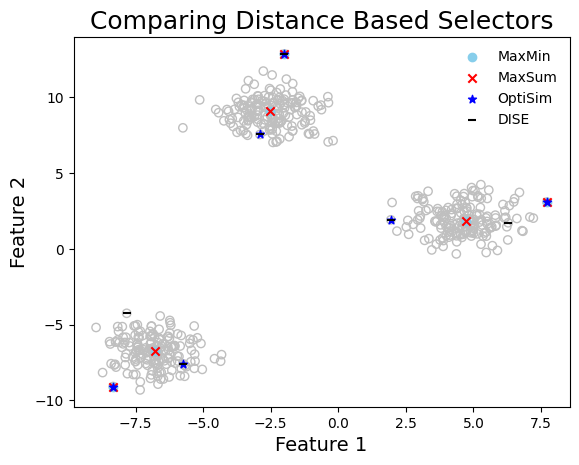

In [23]:
# select data using distance base methods with labels
# ---------------------------------------------------
size = 6

collector = MaxMin()
index_maxmin = collector.select(X_dist, size=size, labels=labels)

collector = MaxSum()
index_maxsum = collector.select(X_dist, size=size, labels=labels)

collector = OptiSim(ref_index=0, tol=0.1)
index_optisim = collector.select(X_dist, size=size, labels=labels)

collector = DISE(ref_index=0, p=2.0)
index_dise = collector.select(X, size=size, labels=labels)

graph_data(
    X,
    indices=[index_maxmin, index_maxsum, index_optisim, index_dise],
    labels=["MaxMin", "MaxSum", "OptiSim", "DISE"],
    title="Comparing Distance Based Selectors",
    xlabel="Feature 1",
    ylabel="Feature 2",
)